## Implementing cloud-top phase retrievals
New data from Olimpia (through Trude) is organized differently.

In [2]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, plot_slf_isotherms
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

ic_obs_dir = 'caliop_olimpia/incloud_slf_olimpia'
ct_obs_dir = 'caliop_olimpia/ct_slf_olimpia'
output_dir = 'figures/'
model_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(ic_obs_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [5]:
obs_files = os.listdir(obs_dir)
file_str = '.npy'
data_files = [x for x in obs_files if file_str in x]   # files with the CALIOP string
data_files.sort()

In [6]:
data_files

['slf_00.npy',
 'slf_05.npy',
 'slf_10.npy',
 'slf_15.npy',
 'slf_20.npy',
 'slf_25.npy',
 'slf_30.npy',
 'slf_35.npy',
 'slf_40.npy']

In [7]:
df = np.zeros((180, 360,len(data_files)))
for i,file in enumerate(data_files):
    _arr = np.load('%s/%s' % (obs_dir, file))
#    _lat_avgs = np.nanmean(_arr, axis=1)
    df[:, :, i] = _arr

iso = np.linspace(0,-40, len(data_files))
lon = np.linspace(0, 359, 360)
lat = np.linspace(-89.5, 89.5, 180)
    
da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso},
                  dims=["lat","lon", "isotherm"])

da = da.sortby('isotherm')

In [8]:
_weights = np.cos(np.pi/180*lat).reshape((180,1))
_holder = np.ones((180,360))

weights = _holder*_weights

da2 = xr.DataArray(data=weights,
                  coords={"lat": lat,
                          "lon": lon},
                  dims=["lat","lon"])

In [9]:
ds = xr.Dataset()
ds['SLF'] = da
ds['cell_weight'] = da2
ds

<xarray.Dataset>
Dimensions:      (isotherm: 9, lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * isotherm     (isotherm) float64 -40.0 -35.0 -30.0 -25.0 ... -10.0 -5.0 0.0
Data variables:
    SLF          (lat, lon, isotherm) float64 nan nan nan nan ... nan nan nan
    cell_weight  (lat, lon) float64 0.008727 0.008727 ... 0.008727 0.008727

In [10]:
os.listdir('NorESM_validation/')

['20191209_143245_singleparam_hetrfrzoslo_elegant_inp10.cam.h0.0001-01.nc',
 '20191210_114516_singleparam_hetrfrzoslo_verbose_inp10',
 '20200129_143703_singleparam_noice_wbf_1_inp_0',
 '20191205_151312_single_param_verbose_inp1.cam.h0.0001-01.nc',
 '20191209_171710_singleparam_hetrfrzoslo_dummies_inp10',
 'unused',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.nc',
 '20200102_105235_singleparam_entraintest_1_1',
 '20191209_122334_singleparam_microandhetrfrz_usingpcols_inp10.cam.h0.0001-01.nc',
 '20200109_1541_wbf_1.0_inp_1.0.cam.h0.2000-01.nc',
 '20191209_120756_singleparam_autohetrfrzoslo_inp10.cam.h0.0001-01.nc',
 '20191210_114516_singleparam_hetrfrzoslo_dummies_inp0.1',
 '20200117_101940_singleparam_nudged_no_sed_1_1',
 '20191206_124753_single_param_manualhetrfrzoslo_inp10.cam.h0.0001-01.nc']

In [25]:
ds.to_netcdf(path='%s/incloud_slfs.nc' % obs_dir)

In [26]:
ds

<xarray.Dataset>
Dimensions:      (isotherm: 9, lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * isotherm     (isotherm) float64 -40.0 -35.0 -30.0 -25.0 ... -10.0 -5.0 0.0
Data variables:
    SLF          (lat, lon, isotherm) float64 nan nan nan nan ... nan nan nan
    cell_weight  (lat, lon) float64 0.008727 0.008727 ... 0.008727 0.008727

# WHY doesn't this work??

In [5]:
ic_slf = xr.open_dataset('%s/incloud_slfs.nc' % ic_obs_dir)
icslfreorg = ic_slf['SLF'].transpose('isotherm','lat','lon')

In [6]:
ct_slf = xr.open_dataset('%s/cloudtop_slfs.nc' % ct_obs_dir)
ctslfreorg = ct_slf['SLF'].transpose('isotherm','lat','lon')

Text(0.5,0.98,'Cloudtop SLF distribution across isotherms')

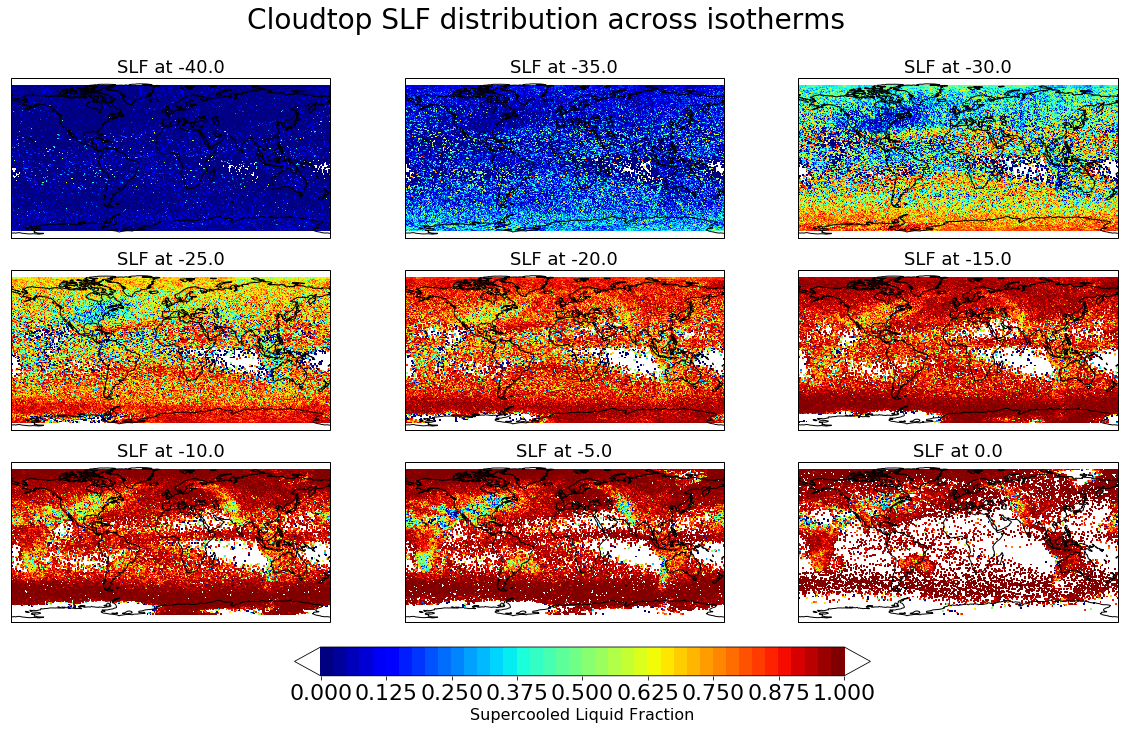

In [10]:
fig1, axes1 = plt.subplots(nrows=3,ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20,10]);

cmin_p = np.nanmin(ctslfreorg)
cmax_p = np.nanmax(ctslfreorg)

cmap_p = 'bwr'
nlevels = 41
cmap2 = plt.get_cmap(cmap_p)

if cmin_p == cmax_p:
   cmax_p = cmax_p + 0.00001

levels = np.linspace(cmin_p,cmax_p,nlevels)

for data, ax in zip(ctslfreorg, axes1.flatten()):
    iso = data['isotherm'].values
    map = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', 
                    robust=True, add_colorbar = False, levels=levels)

    ax.set_title('SLF at %s' % str(iso), fontsize=18)
    ax.coastlines()

cb_ax = fig1.add_axes([0.325, 0.05, 0.4, 0.04])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_xlabel('Supercooled Liquid Fraction', fontsize=16)

fig1.suptitle('Cloudtop SLF distribution across isotherms', fontsize=28)

In [11]:
filename = '/slf_global_map_jet.png'
filename
if not os.path.exists(filename):
    fig1.savefig(ct_obs_dir + filename,format = 'png', dpi = 200)
    fig1.clf()

Text(0.5,0.98,'In-Cloud SLF distribution across isotherms')

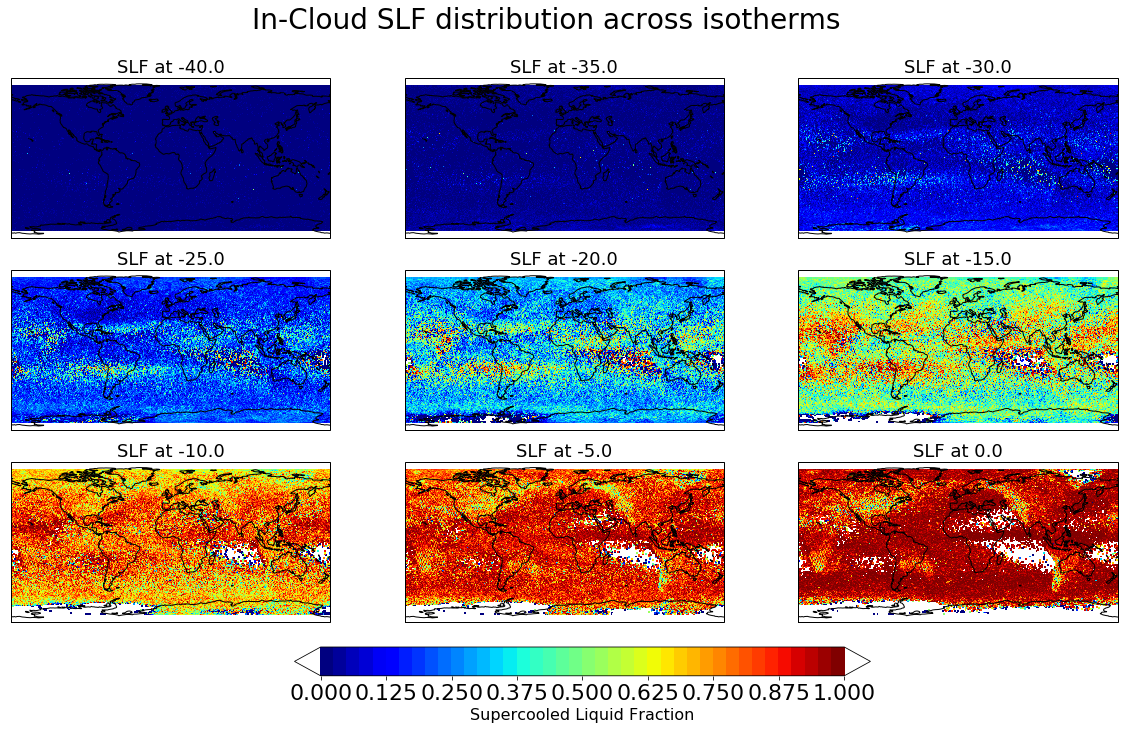

In [7]:
fig2, axes2 = plt.subplots(nrows=3,ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20,10]);

cmin_p = np.nanmin(icslfreorg)
cmax_p = np.nanmax(icslfreorg)

cmap_p = 'bwr'
nlevels = 41
cmap2 = plt.get_cmap(cmap_p)

if cmin_p == cmax_p:
   cmax_p = cmax_p + 0.00001

levels = np.linspace(cmin_p,cmax_p,nlevels)

for data, ax in zip(icslfreorg, axes2.flatten()):
    iso = data['isotherm'].values
    map = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', 
                    robust=True, add_colorbar = False, levels=levels)

    ax.set_title('SLF at %s' % str(iso), fontsize=18)
    ax.coastlines()

cb_ax = fig2.add_axes([0.325, 0.05, 0.4, 0.04])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=22)
cbar.ax.set_xlabel('Supercooled Liquid Fraction', fontsize=16)

fig2.suptitle('In-Cloud SLF distribution across isotherms', fontsize=28)

In [9]:
filename = '/slf_global_map_jet.png'
filename
if not os.path.exists(filename):
    fig2.savefig(ic_obs_dir + filename,format = 'png', dpi = 200)
    fig2.clf()

In [31]:
arctic = 100*da.sel(lat=slice(70,90)).mean(dim=['lat','lon'])
arctic_stdev = 100*np.std(da.sel(lat=slice(70,90)), axis=(0,1)) 
all_lat = 100*da.mean(dim=['lat','lon'])
all_stdev = 100*np.std(da, axis=(0,1)) 

arctic

<xarray.DataArray (isotherm: 9)>
array([ 1.22943513,  2.48153991,  7.89601633, 17.40234618, 29.51989929,
       47.12964984, 66.30329758, 78.46401746, 90.98030564])
Coordinates:
  * isotherm  (isotherm) float64 -40.0 -35.0 -30.0 -25.0 ... -10.0 -5.0 0.0

In [32]:
arctic_stdev

<xarray.DataArray (isotherm: 9)>
array([ 0.90523923,  1.29478282,  2.60273295,  4.10124404,  5.85059676,
        8.00105801,  9.95644345, 12.50253945, 12.85171931])
Coordinates:
  * isotherm  (isotherm) float64 -40.0 -35.0 -30.0 -25.0 ... -10.0 -5.0 0.0

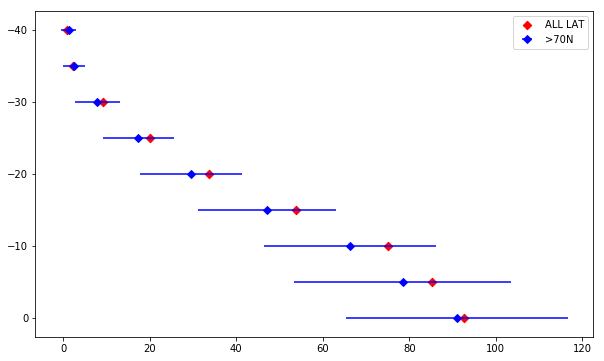

In [33]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
fig1.gca().invert_yaxis()
ax1 = fig1.axes
#ax1[0].scatter(arctic, da['isotherm'], label='>70N', color = 'b')
ax1[0].errorbar(arctic, da['isotherm'], xerr=2*arctic_stdev, label='>70N', color = 'b', fmt='o', marker='D')
#ax1[0].fill_betweenx(da['isotherm'], arctic - 2*arctic_stdev, arctic + 2*arctic_stdev, alpha=0.2)

ax1[0].scatter(all_lat, da['isotherm'], label='ALL LAT', color = 'r', marker='D')
#ax1[0].fill_betweenx(da['isotherm'], all_lat - 2*all_stdev, all_lat + 2*all_stdev, alpha=0.2)
plt.legend()

In [13]:
da = xr.DataArray(data=_arr,
                  coords={"lat": lat,
                          "lon": lon},
                  dims=["lat","lon"])

In [15]:
da2 = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso},
                  dims=["lat","lon", "isotherm"])

Interesting that the SLF at the -10C isotherm is latitude dependent